In [1]:
# Impor Pustaka
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model  # Perbarui impor ini
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [2]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Importing the dataset

from google.colab import drive
drive.mount('/content/drive')

with open(r'/content/drive/MyDrive/Colab Notebooks/updated_dataset_motor2.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter
# Tambahkan data intents dalam json
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    # digunakan untuk pattern atau teks pertanyaan dalam json
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # tambahkan ke dalam list kelas dalam data
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Importing the dataset
with open(r'/content/drive/MyDrive/Colab Notebooks/updated_dataset_motor2.json') as content:
    data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

# Tambahkan data intents dalam json
for intent in data1['intents']:
    tag = str(intent['tag'])  # Konversi tag ke dalam string
    responses[tag] = intent.get('responses', [])  # Mengakses nilai 'responses' dengan metode get()

    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(tag)

        # Digunakan untuk pattern atau teks pertanyaan dalam json
        for pattern in intent['patterns']:
            w = nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w, tag))

            # Tambahkan ke dalam list kelas dalam data
            if tag not in classes:
                classes.append(tag)

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns": inputs, "tags": tags})

In [5]:
# Cetak data keseluruhan
data

,patterns,tags
0,,notfound
1,,notfound
2,,notfound
3,,notfound
4,,notfound
...,...,...
355,Kenapa ada tetesan oli di lantai?,oli_bocor
356,Motor saya bocor oli di bagian mesin,oli_bocor
357,Oli menetes dari bawah mesin,oli_bocor
358,Terdapat rembesan oli di area blok mesin,oli_bocor


In [6]:
# Cetak data baris pertama sampai baris kelima
data.head()

,patterns,tags
0,,notfound
1,,notfound
2,,notfound
3,,notfound
4,,notfound


In [7]:
# Cetak data baris ke-70 sampai baris akhir
data.tail()

,patterns,tags
355,Kenapa ada tetesan oli di lantai?,oli_bocor
356,Motor saya bocor oli di bagian mesin,oli_bocor
357,Oli menetes dari bawah mesin,oli_bocor
358,Terdapat rembesan oli di area blok mesin,oli_bocor
359,Mesin basah oleh oli yang keluar,oli_bocor


In [8]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [9]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

359 unique lemmatized words [',', '.', 'ada', 'agar', 'akhir-akhir', 'aki', 'akselerasi', 'aksesoris', 'alat', 'aman', 'aneh', 'angin', 'apa', 'api', 'area', 'arm', 'aroma', 'asap', 'atas', 'au', 'bagaimana', 'bagian', 'bahan', 'baik', 'bakar', 'ban', 'bantu', 'bantuannya', 'banyak', 'basah', 'bau', 'bawah', 'bebek', 'belakang', 'belum', 'benar', 'bensin', 'berasap', 'berat', 'berbau', 'berbunyi', 'berfungsi', 'bergetar', 'berguncang', 'berhenti', 'berisik', 'berkali-kali', 'berkedip', 'berkendara', 'berlebih', 'berlebihan', 'berlubang', 'bermasalah', 'bersihkan', 'bertenaga', 'berwarna', 'biasa', 'biasanya', 'bisa', 'blok', 'bocor', 'boros', 'bot', 'busi', 'bye', 'cahaya', 'cairan', 'cakram', 'campuran', 'cara', 'cat', 'cek', 'cemerlang', 'cepat', 'cocok', 'cukup', 'dalam', 'dan', 'dari', 'dengan', 'dengungan', 'depan', 'di', 'dicek', 'diganti', 'digas', 'dihidupkan', 'dijalankan', 'dikendarai', 'dilakukan', 'dilepas', 'dipakai', 'diperhatikan', 'diperlukan', 'dipindahkan', 'direkomen

In [10]:
# sorting pada data class
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

101 classes ['aksesoris_motor', 'ban_bergetar', 'bau_knalpot_tidak_wajar', 'cek_ban_motor', 'cek_rantai_motor', 'cek_rem_motor', 'ganti_busi_awal', 'ganti_busi_belum', 'ganti_busi_sudah', 'ganti_lampu_awal', 'ganti_lampu_belakang', 'ganti_lampu_depan', 'ganti_lampu_sein', 'ganti_oli', 'ganti_oli_awal', 'ganti_oli_cara', 'ganti_oli_jadwal', 'jenis_motor', 'kemampuan_bot', 'knalpot_berasap_tebal', 'lampu_redup', 'masalah_ban_awal', 'masalah_ban_dalam', 'masalah_ban_tubeless', 'masalah_karburator_awal', 'masalah_karburator_bersih', 'masalah_karburator_setel', 'masalah_kelistrikan_awal', 'masalah_kelistrikan_lampu', 'masalah_kelistrikan_pengapian', 'masalah_kelistrikan_starter', 'masalah_kopling_awal', 'masalah_kopling_ganti_kampas', 'masalah_kopling_setel_kabel', 'masalah_listrik_motor', 'masalah_radiator_awal', 'masalah_radiator_bersih', 'masalah_radiator_cairan', 'masalah_rem_cakram_awal', 'masalah_rem_cakram_ganti_kampas', 'masalah_rem_cakram_udara', 'masalah_suspensi_awal', 'masalah_s

In [11]:
# documents = kombinasi antara data pattern dengan data tag dalam intents json
print (len(documents), "documents")

1402 documents


In [12]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[],
 [],
 [],
 [],
 [],
 [95],
 [96],
 [61, 97],
 [61, 199],
 [5, 130],
 [200, 131, 2],
 [96, 201],
 [95, 21, 13, 39, 2, 202, 203, 1],
 [1, 2, 76],
 [21, 25, 22, 1, 2],
 [8, 1, 3, 132, 62],
 [1, 2, 77, 133],
 [78, 1, 33, 204],
 [5, 40, 1, 77, 98],
 [6, 4, 16, 15, 1],
 [5, 134, 16, 15],
 [63, 28, 16, 15, 1],
 [8, 1, 2, 64],
 [5, 40, 41, 1, 135],
 [1, 2, 205, 3, 99],
 [8, 1, 2, 100, 9, 26],
 [5, 40, 1, 100],
 [1, 65, 136],
 [79, 80],
 [206],
 [207],
 [79, 80, 137, 208],
 [6, 4, 42, 19, 1],
 [6, 4, 138, 139, 19, 1],
 [6, 4, 140, 19, 1],
 [4, 34, 19, 1],
 [6, 209, 19, 1, 3, 101],
 [6, 4, 42, 7, 1],
 [6, 4, 138, 139, 7, 1],
 [6, 4, 140, 7, 1],
 [5, 141, 7, 1, 3, 49],
 [4, 34, 7, 1, 102, 210, 142],
 [8, 1, 2, 81, 66],
 [5, 40, 14, 1, 67],
 [1, 67, 5, 13, 28, 143],
 [8, 1, 2, 103, 82],
 [5, 40, 211, 82, 1, 144],
 [1, 104, 103, 145, 146, 8],
 [105, 1, 5, 13, 212],
 [50, 213, 105, 1],
 [5, 105, 214, 83, 1],
 [6, 50, 84, 1, 13, 142],
 [5, 106, 13, 28, 215, 9, 216, 1],
 [50, 102, 61, 84, 1],
 [5

In [13]:
# Melakukan proses padding pada data
x_train = pad_sequences(train)
# Menampilkan hasil padding
print(x_train)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...  31 353  14]
 [  0   0 354 ... 197 356  14]
 [  0   0   0 ...  15  13 126]]


In [14]:
# Melakukan konversi data label tags dengan encoding
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[ 63  63  63  63  63  92  92  92  92  92  92  92  92  92  92  58  58  58
  58  13  13  13  51  51  51  56  56  56  97  97  97  97   4   4   4   4
   4   5   5   5   5   5  57  57  57  52  52  52   0   0   0  99  99  99
  17  17  17  34  34  34  98  98  98  91  91  91  91  91  18  18  18  18
  93  93  93  93  93  94  94  94  94  88  88  88  87  87  87  14  14  14
  14  16  16  16  15  15  15  80  80  80  80  82  82  82  81  81  81  21
  21  21  21  23  23  22  22  77  77  77  79  79  79  78  78  78   6   6
   6   8   8   8   8   7   7   7  74  74  74  75  75  75  76  76  76  65
  65  65  66  66  66  67  67  67  68  68  68  69  69  70  70  83  83  83
  85  85  85  84  84  84   9   9   9   9  11  11  11  10  10  10  12  12
  12  24  24  24  24  25  25  25  26  26  26  35  35  35  37  37  37  36
  36  36  38  38  38  39  39  39  40  40  40  31  31  31  33  33  33  32
  32  32  27  27  27  30  30  30  28  28  28  29  29  29  41  41  41  43
  43  43  42  42  42  44  44  44  45  45  45  46  4

In [15]:
# Melihat hasil input pada data teks
input_shape = x_train.shape[1]
print(input_shape)

9


In [16]:
# Melakukan definisi tiap kalimat dan kata pada data teks
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# Melakukan pemeriksaan pada data output label teks
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  357
output length:  101


## **Save Label Encoder & Tokenizer**

In [17]:
# Simpan hasil pemrosesan teks dengan menggunakan pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

In [18]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

In [19]:
# Creating the model (Membuat Modelling)
i = Input(shape=(input_shape,)) # Layer Input
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True, recurrent_dropout=0.2)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x) # Model yang telah disusun dari layer Input sampai layer Output

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [20]:
!pip -q install pydot

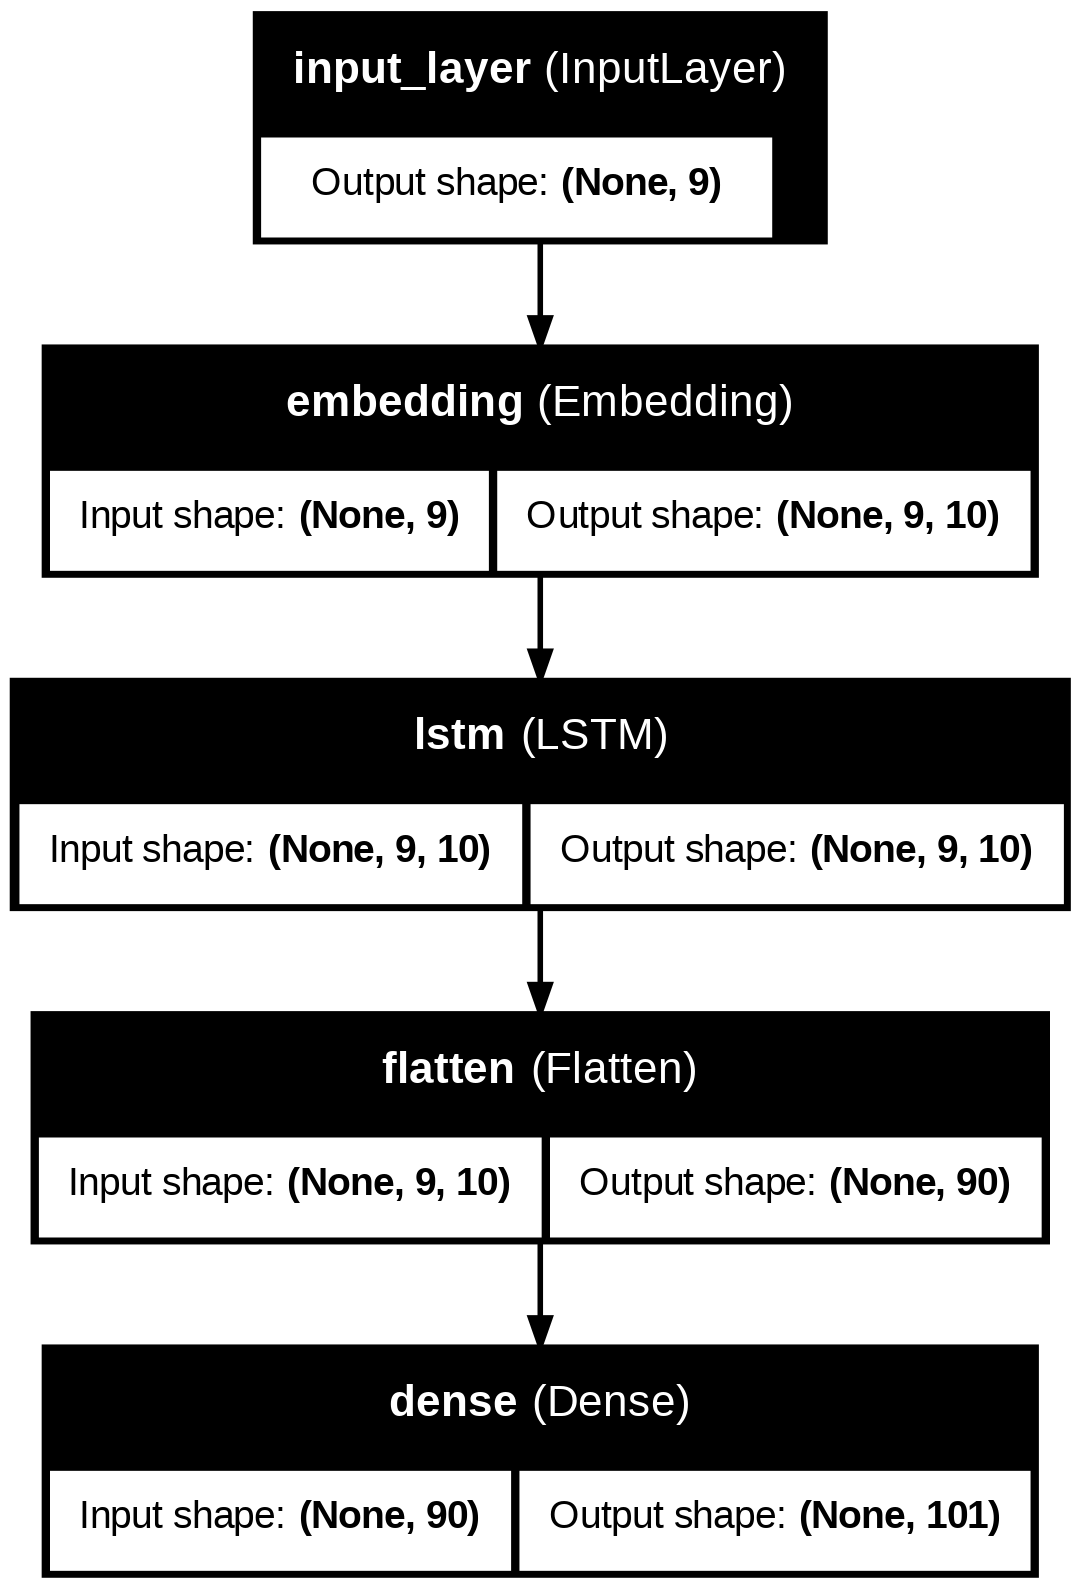

In [21]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
# Menampilkan parameter pada model LSTM
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 9, 10)               │           3,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 9, 10)               │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │           9,191 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,611 (53.17 KB)

 Trainable params: 13,611 (53.17 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Training the model (Melatih model data sampai 450 kali)
train = model.fit(x_train, y_train, epochs=450)

Epoch 1/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0156 - loss: 4.6157
Epoch 2/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0148 - loss: 4.6124
Epoch 3/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0510 - loss: 4.6103
Epoch 4/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0574 - loss: 4.6067
Epoch 5/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0563 - loss: 4.6013
Epoch 6/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0542 - loss: 4.5942
Epoch 7/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0461 - loss: 4.5846
Epoch 8/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0496 - loss: 4.5683
Epoch 9/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0318 - loss: 4.5401
Epoch 10/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0372 - loss: 4.4908
Epoch 11/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0353 - loss: 4.4299
Epoch 12/450
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

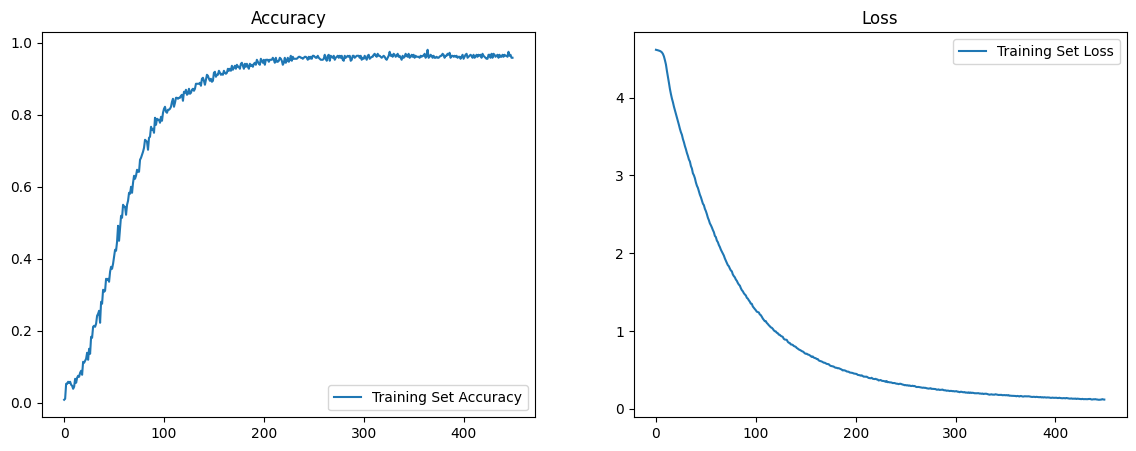

In [24]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [25]:
while True:
    texts_p = []
    prediction_input = input('👨‍🦰 Kamu: ')

    # Menghapus punktuasi/tanda baca, dan konversi ke huruf kecil
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

    # Melakukan Tokenisasi dan Padding pada data teks
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    # Konversi data teks menjadi array
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)

    # Mendapatkan hasil prediksi keluaran pada model
    output = model.predict(prediction_input)
    output = output.argmax()

    # Menemukan respon sesuai data tag
    response_tag = le.inverse_transform([output])[0]
    # Bot akan melakukan random jawaban percakapan dari hasil pertanyaan
    print("🤖 Bot: ", random.choice(responses[response_tag]))
    print("=" * 60 + "\n")

    # Tambahkan respon 'tidak' agar bot bisa berhenti melakukan percakapan
    if response_tag == "tidak":
        print("🤖 Bot: Sampai jumpa lagi!")
        break

👨‍🦰 Kamu: Hai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
🤖 Bot:  Halo!

👨‍🦰 Kamu: pa yang bisa kamu lakukan?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
🤖 Bot:  Saya dapat membantu Anda dengan panduan perbaikan dan perawatan motor. Silakan tanyakan apa yang ingin Anda ketahui!

👨‍🦰 Kamu: Motor saya bermasalah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
🤖 Bot:  Maaf mendengar itu. Bisa Anda jelaskan lebih detail masalah pada motor Anda agar saya bisa membantu?

👨‍🦰 Kamu: Masalah pada spion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
🤖 Bot:  Apakah spion Anda patah atau kaca spion retak?

👨‍🦰 Kamu: Spion patah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
🤖 Bot:  Untuk memperbaiki spion yang patah, Anda perlu mengganti spion tersebut.

**Langkah-langkah:**
1. Beli spion pengganti yang sesuai dengan motor Anda.
2. Siapkan obeng dan kunci pas.
3. Lepaskan spion yang patah dengan membuka baut pengikat.
4. Pasang spion baru dan kencangkan baut pengikat.

**Alat dan Bahan:** Spion baru, obeng, kunci pas.

👨‍🦰 Kamu: Bagaim

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from google.colab import files

# Contoh model sederhana
model = Sequential([
    Dense(10, activation='relu', input_shape=(20,)),
    Dense(1, activation='sigmoid')
])

# Simpan model dalam format .h5
model.save('modelcapstone.h5')

# Unduh file .h5
files.download('modelcapstone.h5')

print('Model Created and Downloaded Successfully in .h5 format!')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Created and Downloaded Successfully in .h5 format!


In [27]:
# Simpan model dalam bentuk format file .h5
# model.save('/content/drive/My Drive/Colab Notebooks/modelcapstone.h5')

# print('Model Created and Saved Successfully in .h5 format!')


# ### Simpan model ke dalam format .pkl (pickle)
# with open('/content/drive/My Drive/Colab Notebooks/modelcapstone.pkl', 'wb') as file:
    # pickle.dump(model, file)

# print('Model Created and Saved Successfully in .pkl format!')